# Auto tuning

## The processes
The processes studied in this session are third order systems with two poles in $s=-0.5$ and one pole in -2.
$$P(s) = \dfrac{1}{(2s+1)^2(0.5s+1)}$$
with or without input nonlinearity.

## Installation
- First of all, you need Julia installed, see https://julialang.org/downloads/
- You also need [IJulia](https://github.com/JuliaLang/IJulia.jl#installation), which in turn requires Jupyter.
- Once Julia is up and running, the following julia code only has to be run once, it installs the relevant packages.

The code below must be run once every time the kernel is restarted

In [37]:
using ControlSystems, OrdinaryDiffEq, Plots, Interact, Pkg, LinearAlgebra, Statistics
gr(show=false, size=(500,400)) # Set defaults for plotting

Plots.GRBackend()

We now proceed to define the process model and some parameters for our simulation

In [39]:
P              = tf(1,[2.,1])^2*tf(1,[0.5,1])  # Process model
h              = 0.1             # Sample time (only used for plots)
Ps             = ss(P);          # State-space representation of process model

In [3]:
s      = Simulator(Ps)
x0     = [0.,0,0] # Initial state
Tf     = 20              # Length of experiments (seconds)
t      = 0:h:Tf          # Time vector
tspan  = (0.0,Tf)

(0.0, 20)

## Auto tuning
Even with interactive tools, tuning a PID controller by hand can be difficult. A basic control course teaches us how to design a PID controller based on, e.g., pole placement. Here, we will formulate an optimization problem where we optimize a cost function $J(k_p,k_i,k_d)$ based on the step response of the closed-loop system
$$J(k_p,k_i,k_d) \quad=\quad \dfrac{1}{T_f}\int_0^{T_f} |r(t)-y(t)| dt \quad=\quad \dfrac{1}{T_f}\int_0^{T_f} |e(t)|dt$$

In [8]:
Pkg.add("NLopt") # Install NLopt if not already installed

INFO: Package NLopt is already installed


┌ Info: Starting Optimization
└ @ Main In[41]:42


 19.197027 seconds (10.87 M allocations: 600.333 MiB, 6.58% gc time)


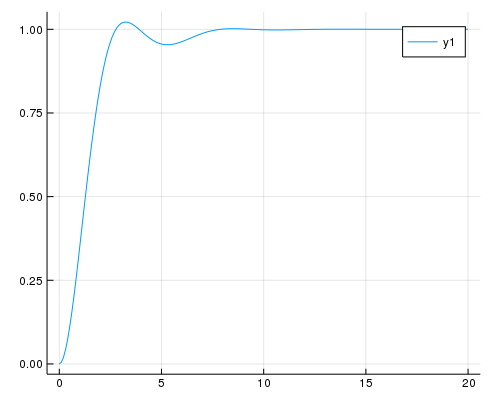

In [41]:
using NLopt, ForwardDiff
p              = [0.1, 0.1, 0.1] # Initial guess [kp, ki, kd]
Kpid(kp,ki,kd) = pid(kp=kp, ki=ki, kd=kd)
Kpid(p)        = K(p...)

function timedomain(p)
    C     = Kpid(p[1], p[2], p[3])
    L     = feedback(P*C) |> ss
    s     = Simulator(L, (x,t) -> [1]) # Sim. unit step load disturbance
    ty    = eltype(p) # So that all inputs to solve have same numerical type (ForwardDiff.Dual)
    x0    = zeros(L.nx) .|> ty
    tspan = (ty(0.),ty(Tf))
    sol   = solve(s, x0, tspan)
    y     = L.C*sol(t) # y = C*x
    y
end

function costfun(p)
    y = timedomain(p)
    mean(abs,1 .- y) # ~ Integrated absolute error IAE
end

f_cfg = ForwardDiff.GradientConfig(costfun, p)

function f(p::Vector, grad::Vector)
    if length(grad) > 0
        grad .= ForwardDiff.gradient(costfun,p,f_cfg)
    end
    costfun(p)
end

function runopt(p; f_tol = 1e-5, x_tol = 1e-3)
    opt = Opt(:LD_AUGLAG, 3)
    lower_bounds!(opt, 1e-6ones(3))
    xtol_rel!(opt, x_tol)
    ftol_rel!(opt, f_tol)

    min_objective!(opt, f)
    NLopt.optimize(opt, p)[2]
end

@info "Starting Optimization"
@time p = runopt(p, x_tol=1e-6)
y = timedomain(p)
plot(t,y')

If we look at the sensitivity function of the closed-loop system obtained with the optimized controller, we see that the optimization procedure produced a quite aggressive controller with poor robustness. 

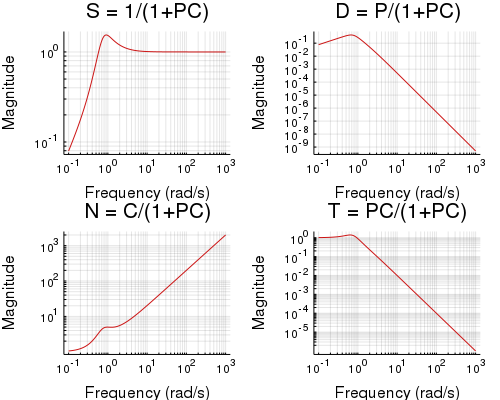

In [43]:
C     = Kpid(p...)
gangoffourplot(P,C, exp10.(LinRange(-1,3,500)), legend=false)

To combat this, we can add bounds on the maximum value of the sensitivity functions:

In [46]:
Ω  = exp10.(LinRange(-1,2,150))
p0 = [0.1,0.1,0.1]
function freqdomain(p)
    C     = Kpid(p[1], p[2], p[3])
    S     = 1/(1+P*C) # Sensitivity fun
    T     = tf(1.) - S# Comp. Sensitivity fun
    Sw    = vec(bode(S,Ω)[1]) # Freq. domain constraints
    Tw    = vec(bode(T,Ω)[1]) # Freq. domain constraints
    Sw,Tw
end
Mt = 1.5
@manipulate for Ms = LinRange(1.1,2,20)
    global p0, p
    p = p0
    function constraintfun(p)
        Sw,Tw = freqdomain(p)
        [maximum(Sw)-Ms; maximum(Tw)-Mt]
    end

    g_cfg = ForwardDiff.JacobianConfig(constraintfun, p)

    function c(result, p::Vector, grad)
        if length(grad) > 0
            grad .= ForwardDiff.jacobian(constraintfun,p,g_cfg)'
        end
        result .= constraintfun(p)
    end

    function runopt(p; f_tol = 1e-5, x_tol = 1e-3, c_tol = 1e-8)
        opt = Opt(:LD_SLSQP, 3)
        lower_bounds!(opt, 1e-6ones(3))
        xtol_rel!(opt, x_tol)
        ftol_rel!(opt, f_tol)

        min_objective!(opt, f)
        inequality_constraint!(opt, c, c_tol*ones(2))
        NLopt.optimize(opt, p)[2]
    end


    p = runopt(p, x_tol=1e-6)
    y = timedomain(p)
    Sw,Tw = freqdomain(p)
    plot(t,y', layout=2, size=(800,400))
    plot!(Ω, [Sw Tw] , lab=["Sw" "Tw"], subplot=2, xscale=:log10, yscale=:log10)
    plot!([Ω[1],Ω[end]], [Ms,Ms], c = :black, l=:dash, subplot=2, lab="Ms")
    plot!([Ω[1],Ω[end]], [Mt,Mt], c = :purple, l=:dash, subplot=2, lab="Mt", ylims=(0.01,3))
end

Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:Ms=>Widget{:slider,Float64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64} with 1 listeners. Value:
0,:index=>Observable{Any} with 2 listeners. Value:
10,:formatted_vals=>Observable{Any} with 1 listeners. Value:
["1.1", "1.14737", "1.19474", "1.24211", "1.28947", "1.33684", "1.38421", "1.43158", "1.47895", "1.52632", "1.57368", "1.62105", "1.66842", "1.71579", "1.76316", "1.81053", "1.85789", "1.90526", "1.95263", "2.0"],:formatted_value=>Observable{String} with 1 listeners. Value:
"1.52632",:value=>Observable{Float64} with 2 listeners. Value:
1.52632), Observable{Float64} with 2 listeners. Value:
1.52632, Scope("knockout-component-7594805e-e762-4b79-9974-0c90949735a4", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["Ms"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"text-align:right;width:18%")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>20,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: index, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"flex-grow:1; margin: 0 2%")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: formatted_value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"width:18%")), 1)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"display:flex; justify-content:center; align-items:center;")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("formatted_vals"=>(Observable{Any} with 1 listeners. Value:
["1.1", "1.14737", "1.19474", "1.24211", "1.28947", "1.33684", "1.38421", "1.43158", "1.47895", "1.52632", "1.57368", "1.62105", "1.66842", "1.71579", "1.76316", "1.81053", "1.85789", "1.90526", "1.95263", "2.0"], nothing),"changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"formatted_value"=>(Observable{String} with 1 listeners. Value:
"1.52632", nothing),"index"=>(Observable{Any} with 2 listeners. Value:
10, nothing)), Set(String[]), nothing, Any["knockout"=>"/local/home/fredrikb/.julia/packages/Knockout/JIqpG/src/../assets/knockout.js", "knockout_punches"=>"/local/home/fredrikb/.julia/packages/Knockout/JIqpG/src/../assets/knockout_punches.js", "/local/home/fredrikb/.julia/packages/InteractBase/Q4IkI/src/../assets/all.js", "/local/home/fredrikb/.julia/packages/InteractBase/Q4IkI/src/../assets/style.css", "/local/home/fredrikb/.julia/packages/InteractBulma/Ohu5Y/src/../assets/main.css"], Dict{Any,Any}("formatted_vals"=>Any[JSString("(function (val){return (val!=this.model[\"formatted_vals\"]()) ? (this.valueFromJulia[\"formatted_vals\"]=true, this.model[\"formatted_vals\"](val)) : undefined})")],"_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: str

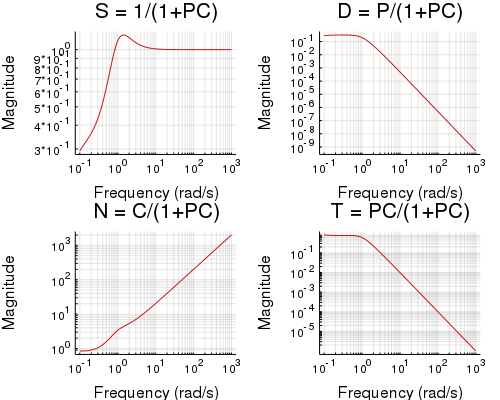

In [48]:
C     = Kpid(p...)
gangoffourplot(P,C, exp10.(LinRange(-1,3,500)), legend=false)